This file is created by Bang Nguyen for beginner of the M5 competition to easily understand and start making your first notebook to solve the problem.

I do collect some codes from other notebooks.

Give me an UPVOTE, if it is useful!

Thank you!

****IMPORT PACKAGES**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
import seaborn as sns
from itertools import cycle

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **DATA EXPLORATION**

#From the "M5 competitors Guide Final" file.

The M5 dataset involves the unit sales organize in the form of grouped time series.

More specifically, the data set involves that unit sales of **3,049 products** classified in **3 product categories** (Hobbies, Foods, and Household) and **7 product departments**.

The products are sold across **ten stores**, located in **three States** (CA, TX and WI).


Level 
id	Aggregation Level	Number of series

1	Unit sales of all products, aggregated for all stores/states	1

2	Unit sales of all products, aggregated for each State	3

3	Unit sales of all products, aggregated for each store 	10

4	Unit sales of all products, aggregated for each category	3

5	Unit sales of all products, aggregated for each department	7

6	Unit sales of all products, aggregated for each State and category	9

7	Unit sales of all products, aggregated for each State and department	21

8	Unit sales of all products, aggregated for each store and category	30

9	Unit sales of all products, aggregated for each store and department	70

10	Unit sales of product x, aggregated for all stores/states	3,049

11	Unit sales of product x, aggregated for each State	9,147

12	Unit sales of product x, aggregated for each store	30,490

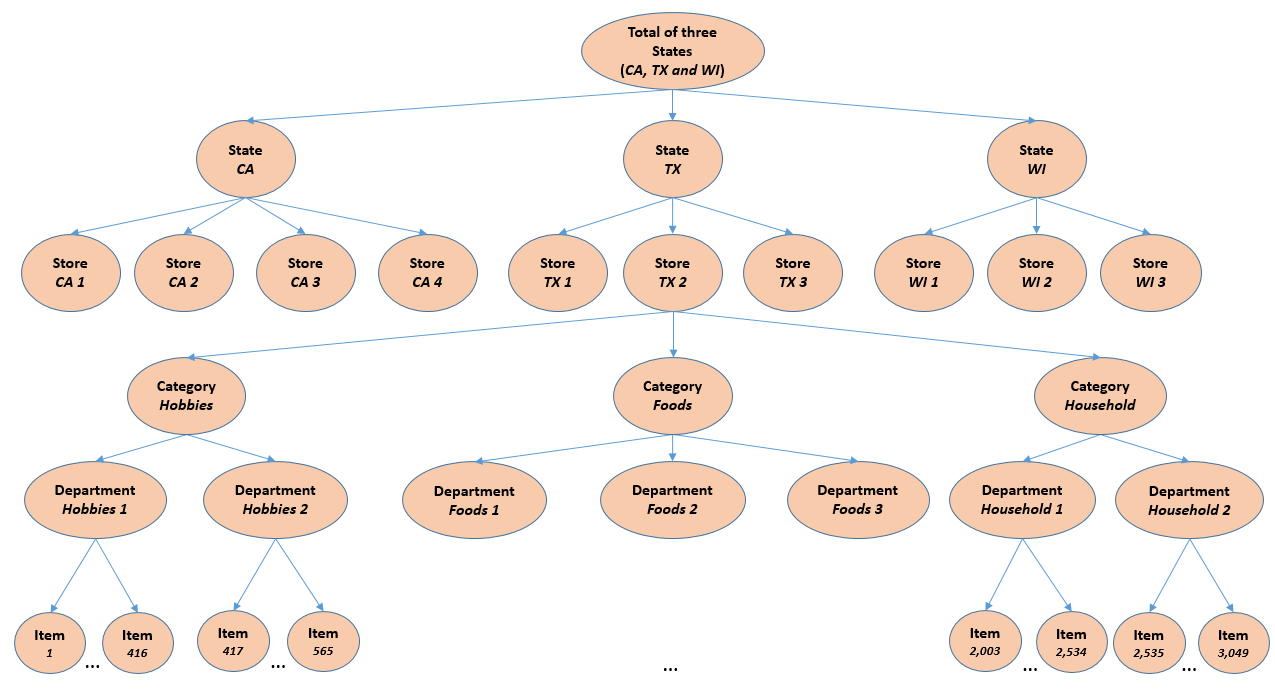

The historical data range from **2011-01-29 ** to **2016-06-19** => the selling history of 1,941 days/5.4 years.

The dataset includes these files: calendar.csv; sales_train_validation.csv; sell_prices.csv.(and sample_submission.csv)

In [ ]:
# Read in the data
INPUT_DIR = '../input/m5-forecasting-accuracy'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
sales_train_validation = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sell_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
#sample_submission = sample_submission.set_index('id')


In [ ]:
#Explain the data of CALENDAR
#calendar.csv (1969 rows; 14 columns) contains information about the dates the products are sold
#1)date in y-m-d formate. 2)wm_yr_wk:the id of the week the date belongs to
#3)weekday: The type of the day (Monday, Teusday ...)
#4)wday: the id of the weekday starting from Saturday 5)month 6)year
#7)d: the day id: d_1, d_2,....d_1941 (but in the file, there are 1969 unique values?)
#8)event_name_1 9)event_type_1 10)event_name_2 11)event_type_2 => If the date includes events: name and type of these events.
#12)snap_CA 13)snap_TX 14)snap_WI: a binary variable (0 or 1) indicating whether the stores of CA, TX or WI 
#allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.
#SNAP: Supplement Nutrition Assistance Program. 
#SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products
#In many states, the monetary benefits are dispersed to people across 10 days of the month 
#and on each of these days 1/10 of the people will receive the benefit on their card
calendar.head()

In [ ]:
#Explain the data of SALES PRICE
#sales_prices.csv (~6.84m rows; 4 columns) contains information about the price of the products sold per store and date
#1) store_id: The id of the store where the product is sold
#2) item_id: The id of the product
#3) wm_yr_wk: The id of the week
#4) sell_price: The price of the product for the given week/store. The price is provided per week (average acrros seven days).
#If not available, this means that the products was not sold during the examined week.
#Noted that although prices are constant at weekly basis, they may change through time (both training and test set)
sell_prices.head()

In [ ]:
#Explain the data of SALES TRAIN 
# sales_train_validation.csv (30.49k rows; 1919 columns) Contain the historical daily unit sales data per product and store
# 1)id: id of the product
# 2)item_id: The id of the product
# 3)dept_id: The id of the department the product belong to
# 4)cat_id: The id of the category the product belong to
# 5)store_id: The id of the store where the product is sold
# 6)state_id: The State where the store is located.
# 7)d_1, d_2, ...d_1941: The number of units solds at day_i, starting from 2011-01-29
sales_train_validation.head()

WHAT EXACTLY ARE WE TRYING TO PREDICT?

In [ ]:
#Seeing what is in the sample_submission.csv file & what do we have to do?
#The columns represent 28 forecast days. We will fill these forecast days with our predictions
#The rows represent a specific item. This id tells us the item type, state, and store.
sample_submission.head()

# **THE BASE-LINE MODEL**

**Requirements**: The number of forecasts required, both for point (**ACCURACY**) and probabilistic (**UNCERTAINTY**) forecasts, is **h=28 days**

The performance measures are **first computed for each series** separately by averaging their values across the forecasting horizon 
and then **averaged again across the series** in a weighted fashion to obtain the final scores.

**Point forcasts**: The accuracy of the point forecasts will be evaluated using the **Root Mean Squared Scaled Error (RMSSE)** 

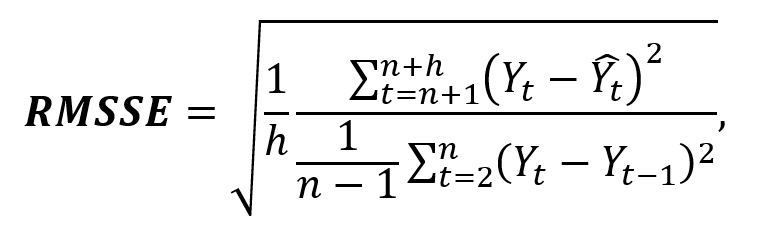

where Y_t is the actual future value of the examined time series at point t, (Y_t ) ̂ the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon.

**PROBABILISTIC forcasts**: The accuracy of the point forecasts will be evaluated using the **Weighted Scaled Pinball Loss (WSPL)** 

**DATA ANALYSIS**

Lets see how the sales of an item look across 1751 days of the training data
These codes are from
> https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

In [ ]:
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
# getting the sales data columns ['d_1','d_2','d_3'...,'d_1913']
data_columns = [c for c in sales_train_validation.columns if 'd_' in c] 

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
# choose the item id 'FOODS_3_090_CA_3_validation'
sales_train_validation.loc[sales_train_validation['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[data_columns] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
# Get the sales data of an item ('FOODS_3_090_CA_3_validation')
example1 = sales_train_validation.loc[sales_train_validation['id'] == 'FOODS_3_090_CA_3_validation'][data_columns].T
# Rename, since 'FOODS_3_090_CA_3_validation' have the index 8412
example1 = example1.rename(columns={8412:'FOODS_3_090_CA_3'}) 
# make the index "d"
example1 = example1.reset_index().rename(columns={'index': 'd'})
example1.head()

In [ ]:
# Merge information from calendar to the sales data
example1 = example1.merge(calendar, how='left', validate='1:1')
example1.head()

In [ ]:
# Select more top selling examples
example2 = sales_train_validation.loc[sales_train_validation['id'] == 'HOBBIES_1_234_CA_3_validation'][data_columns].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(calendar, how='left', validate='1:1')

example3 = sales_train_validation.loc[sales_train_validation['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][data_columns].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar, how='left', validate='1:1')

**THE AVERAGE SALES ON WEEK, MONTH, AND YEAR **

In [ ]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example1, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

THE OBSERVATION ON DIFFENT ITEMS
* It is common to see an item unavailable for a period of time.
* Some items only sell 1 or less in a day, making it very hard to predict.
* Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these

In [ ]:
twenty_examples = sales_train_validation.sample(20, random_state=529) \
        .set_index('id')[data_columns] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

**THE OBSERVATION ON COMBINED SALES OVER TIME by TYPE**

Plot the total demand over time for each type

In [ ]:
sales_train_validation.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()
sales_train_validation['cat_id'].unique()

In [ ]:
past_sales = sales_train_validation.set_index('id')[data_columns] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()


**Rollout of items being sold**

Since, some items come into supply that previously did not exist. Similarly some items stop being sold completely.

Lets plot the sales, but only count if item is selling or not selling.(0 -> not selling, >0 -> selling)

This plot shows us that many items are being slowly introduced into inventory, so many of them will not register a sale at the begining of the provided data.

In [ ]:
past_sales_clipped = past_sales.clip(0, 1)
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()

**Sales by Store**

In [ ]:
store_list = sell_prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Looking at the same data a different way, we can plot a rolling 7 day total demand count by store. Note clearly that some stores have abrupt changes in their demand, it could be that the store expanded or a new competitor was built near by. Either way this is imporant to note when creating predictive models about demand pattern.

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# Sales Heatmap Calendar
It appears that walmarts are closed on Chirstmas day. The highest demand day of all the data was on Sunday March 6th, 2016. What happened on this day you may ask... well the Seventh Democratic presidential candidates debate hosted by CNN and held in Flint, Michigan... I doubt that impacted sales though :D

In [ ]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

Calmap function

In [ ]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------

def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

In [ ]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in sales_train_validation['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

Some interesting things to note from these heatmaps:

* Food tends to have lower number of purchases as the month goes on. Could this be because people get their paychecks early in the month?
* Household and Hobby items sell much less in January - after the Holiday season is over.
* Cleary weekends are more popular shopping days regardless of the item category.

# Sales Prices
We are given historical sale prices of each item. Lets take a look at our example item from before.

* It looks to me like the price of this item is growing.
* Different stores have different selling prices.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sell_prices.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

In [ ]:
sell_prices['Category'] = sell_prices['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sell_prices.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

# The Base-line submission
**1. Naive:** A random walk model, defined as Y_n+1=Y_n, i = 1, 2, 3,...,h. The forecasting method is used for predicting the series of the lowest level of the hierarchy (level 12 of Table 1) and the bottom-up method is then used for reconciliation.

**2. Seasonal Naive (sNaive) ** :Like Naive, but this time the forecasts of the model are equal to the last known observation of the same period in order for it to capture possible weekly seasonal variations. The forecasting method is used for predicting the series of the lowest level of the hierarchy (level 12 of Table 1) and the bottom-up method is then used for reconciliation. 

The average value from the past 30 days

In [ ]:
thirty_day_avg_map = sales_train_validation.set_index('id')[data_columns[-30:]].mean(axis=1).to_dict()
fcols = [f for f in sample_submission.columns if 'F' in f]
for f in fcols:
    sample_submission[f] = sample_submission['id'].map(thirty_day_avg_map).fillna(0)
    
sample_submission.to_csv('submission_average_30d.csv', index=False)